<a href="https://colab.research.google.com/github/oluwafemiomitusa/Urbanization-and-Climate-Change/blob/main/landscape_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Colab on my Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install modules

!pip install -q pyproj rasterio shapely geopandas fiona pycrs fiona pylandstats rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires gast<=0.4.0,>=0.2.1, but you have gast 0.5.4 which is incompatible.


In [ ]:
# Import modules

import pyproj
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import json
import numpy as np
from pylandstats import Landscape
import rioxarray as rxr
import rasterio as rio
import pandas as pd
import warnings

# Ignore specific warning (e.g., FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Convert the geographical coordinates to Cartesian coordinates

In [ ]:
# Define the projection string
projection_string = "+proj=aea +lat_0=0 +lon_0=-95.3698 +lat_1=29.7604 +lat_2=29.7604 +x_0=0 +y_0=0 +ellps=krass +units=m +no_defs"

# Create a Proj object
proj = pyproj.Proj(projection_string)

# Define the geographical coordinates (lists)
latitudes = [29.717, 29.64586, 29.61667, 29.98438, 30.06801, 29.51924, 29.5, 29.61971, 29.726]  # Example latitudes
longitudes = [-95.383, -95.28212, -95.1667, -95.3607, -95.5563, -95.2423, -95.477, -95.6575, -95.266]  # Example longitudes

# Convert latitudes, longitudes, and altitudes to Cartesian coordinates
coordinates = []
for latitude, longitude in zip(latitudes, longitudes):
    x, y = proj(longitude, latitude, radians=False)
    coordinates.append((x, y))

# Print the Cartesian coordinates
for i, (x, y) in enumerate(coordinates):
    print(f"Coordinates {i + 1}: {x}, {y}")


Coordinates 1: -1277.2388951768814, 3167943.2284226264
Coordinates 2: 8489.951879005079, 3160060.5874214694
Coordinates 3: 19671.62048415247, 3156839.0186616005
Coordinates 4: 878.1840763710006, 3197582.7009804193
Coordinates 5: -17982.961762739567, 3206867.8829988353
Coordinates 6: 12361.177824295924, 3146028.76427377
Coordinates 7: -10395.065660724782, 3143894.104411436
Coordinates 8: -27864.853228638654, 3157193.4149715956


# Add 2 km to the WGS84 coordinates and convert back to geographic coordinates

In [ ]:
# Define the input latitude and longitude lists
latitude_list = [29.717, 29.64586, 29.61667, 29.98438, 30.06801, 29.51924, 29.5, 29.61971, 29.726]
longitude_list = [-95.383, -95.28212, -95.1667, -95.3607, -95.5563, -95.2423, -95.477, -95.6575, -95.266]

# Define the UTM zone based on the longitude
utm_zone = 15

# Create the UTM projection based on the UTM zone
utm_proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')

# Create a list to store the coordinates
coordinates_data = []

# Iterate over the coordinates and calculate +2km and -2km values
for i in range(len(latitude_list)):
    # Get the latitude and longitude
    latitude = latitude_list[i]
    longitude = longitude_list[i]

    # Convert latitude and longitude to UTM coordinates
    easting, northing = utm_proj(longitude, latitude)

    # Calculate the +2km and -2km values
    easting_plus_2km = easting + 2000
    northing_plus_2km = northing + 2000
    easting_minus_2km = easting - 2000
    northing_minus_2km = northing - 2000

    # Convert the +2km and -2km UTM coordinates back to latitude and longitude
    longitude_plus_2km, latitude_plus_2km = utm_proj(easting_plus_2km, northing_plus_2km, inverse=True)
    longitude_minus_2km, latitude_minus_2km = utm_proj(easting_minus_2km, northing_minus_2km, inverse=True)

    # Append the coordinates to the list
    coordinates_data.append({
        "original": (longitude, latitude),
        "-2km": (longitude_minus_2km, latitude_minus_2km),
        "+2km": (longitude_plus_2km, latitude_plus_2km)
    })

# Print the list of coordinates (optional)
for i, data in enumerate(coordinates_data):
    print(f"Coordinates {i+1}: {data['original']}")
    print(f"-2km Coordinates: {data['-2km']}")
    print(f"+2km Coordinates: {data['+2km']}")
    print()


Coordinates 1: (-95.383, 29.717)
-2km Coordinates: (-95.40323036479282, 29.698592269250458)
+2km Coordinates: (-95.36276226189948, 29.735404997853806)

Coordinates 2: (-95.28212, 29.64586)
-2km Coordinates: (-95.30235652955776, 29.627467282752118)
+2km Coordinates: (-95.26187612142118, 29.66424997010947)

Coordinates 3: (-95.1667, 29.61667)
-2km Coordinates: (-95.18695323486591, 29.598294048224062)
+2km Coordinates: (-95.14643942462449, 29.635043181786745)

Coordinates 4: (-95.3607, 29.98438)
-2km Coordinates: (-95.38098517843227, 29.96597317354342)
+2km Coordinates: (-95.34040734785393, 30.00278405462676)

Coordinates 5: (-95.5563, 30.06801)
-2km Coordinates: (-95.5765626109345, 30.049574294675246)
+2km Coordinates: (-95.53602988827171, 30.086442968088647)

Coordinates 6: (-95.2423, 29.51924)
-2km Coordinates: (-95.2625205142135, 29.500853996028514)
+2km Coordinates: (-95.22207218276755, 29.53762326363963)

Coordinates 7: (-95.477, 29.5)
-2km Coordinates: (-95.4971718526616, 29.481580

# Since we have successfully added 2 km to our geographic coordinates, utilize the code to create multiple rasters based on provided geographic locations.

In [ ]:
# Load the GeoTIFF file
data = rasterio.open('/content/drive/My Drive/GEE/Houston.tif')

# Define the UTM zone based on the longitude
utm_zone = 15

# Create the UTM projection based on the UTM zone
utm_proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')

# Define the input latitude and longitude lists
latitude_list = [29.717, 29.64586, 29.61667, 29.98438, 30.06801, 29.51924, 29.5, 29.61971, 29.726]
longitude_list = [-95.383, -95.28212, -95.1667, -95.3607, -95.5563, -95.2423, -95.477, -95.6575, -95.266]

# Iterate over the coordinates and calculate +2km and -2km values
for i in range(len(latitude_list)):
    # Get the latitude and longitude
    latitude = latitude_list[i]
    longitude = longitude_list[i]

    # Convert latitude and longitude to UTM coordinates
    easting, northing = utm_proj(longitude, latitude)

    # Calculate the +2km and -2km values
    easting_plus_2km = easting + 2000
    northing_plus_2km = northing + 2000
    easting_minus_2km = easting - 2000
    northing_minus_2km = northing - 2000

    # Convert the +2km and -2km UTM coordinates back to latitude and longitude
    longitude_plus_2km, latitude_plus_2km = utm_proj(easting_plus_2km, northing_plus_2km, inverse=True)
    longitude_minus_2km, latitude_minus_2km = utm_proj(easting_minus_2km, northing_minus_2km, inverse=True)

    # Print the original, +2km, and -2km coordinates
    #print(f"Coordinates {i+1}: {longitude}, {latitude}")
    #print(f"-2km Coordinates: {longitude_minus_2km}, {latitude_minus_2km}")
    #print(f"+2km Coordinates: {longitude_plus_2km}, {latitude_plus_2km}")

    # Define your box (minx, miny, maxx, maxy) in the same CRS as your GeoTIFF file
    bbox = box(longitude_minus_2km, latitude_minus_2km, longitude_plus_2km, latitude_plus_2km)

    # Create a GeoDataFrame
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

    # Change the CRS of the GeoDataFrame to match the GeoTIFF
    geo = geo.to_crs(crs=data.crs.data)

    def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio can take them"""
        return [json.loads(gdf.to_json())['features'][0]['geometry']]

    # Get the geometry in the correct format
    coords = getFeatures(geo)

    # Mask the data
    out_img, out_transform = rasterio.mask.mask(data, shapes=coords, crop=True)
    out_meta = data.meta.copy()

    # Save the result
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform})

    # Save the output for each set of coordinates in separate files
    output_filename = f"/content/drive/My Drive/GEE/rasters/output_{i+1}.tif"
    with rasterio.open(output_filename, "w", **out_meta) as dest:
        dest.write(out_img)


# Check one of the rasters to make sure our operation was successful.

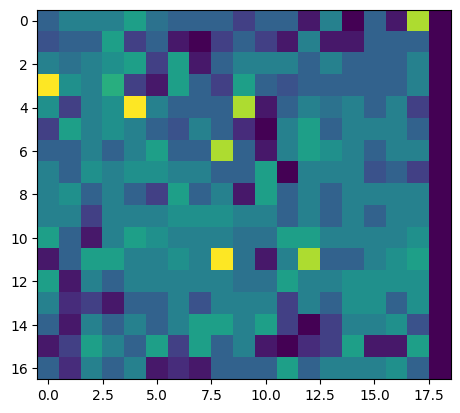

In [ ]:
import matplotlib.pyplot as plt
import rasterio as rio
with rio.open('/content/drive/My Drive/GEE/rasters/output_1.tif') as src:
    plt.imshow(src.read(1))

# Now we implement PyLandStats to capture the landscape metrics.

In [ ]:
# Open dataset
raster = rxr.open_rasterio("/content/drive/My Drive/GEE/rasters/output_1.tif", masked=True).squeeze()
raster = raster.astype(int)

# Load in raster as rioxarray
ls=Landscape(raster.values, res=(len(raster.x),len(raster.y)))

# Compute class-level metrics
class_level = ls.compute_class_metrics_df(['number_of_patches', 'patch_density', 'largest_patch_index', 'shape_index_mn', 'total_edge', 'total_area', 'proportion_of_landscape', 'edge_density', 'euclidean_nearest_neighbor_mn', 'fractal_dimension_mn', 'landscape_shape_index', 'perimeter_area_ratio_mn'])
landscape_level = ls.compute_landscape_metrics_df(['shannon_diversity_index', 'entropy'])

# Add lon and latitude to landscape_level to facilitate matching with temperature dataset
landscape_level['latitude'] = latitude_list[0]
landscape_level['longitude'] = longitude_list[0]
landscape_level.set_index(pd.Index([1]), inplace=True)

# Join the class-level and landscape-level metrics
ls_values = class_level.join(landscape_level, how='outer')

# Fill NaN values in multiple columns with their respective first non-NaN value
columns_to_fill = ['shannon_diversity_index', 'entropy', 'latitude', 'longitude']
for col in columns_to_fill:
    ls_values[col].fillna(method='ffill', inplace=True)

ls_values

/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 10 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(


,number_of_patches,patch_density,largest_patch_index,shape_index_mn,total_edge,total_area,proportion_of_landscape,edge_density,euclidean_nearest_neighbor_mn,fractal_dimension_mn,landscape_shape_index,perimeter_area_ratio_mn,shannon_diversity_index,entropy,latitude,longitude
1,16,165.118679,1.333333,1.132176,1368,0.7429,7.666667,141.176471,43.781439,1.031994,4.606015,2179.760062,1.889223,2.725572,29.717,-95.383
2,5,51.599587,0.333333,1.001547,271,0.1615,1.666667,27.966976,98.930024,1.000535,2.239527,2229.102167,1.889223,2.725572,29.717,-95.383
3,13,134.158927,1.000000,1.152576,1224,0.6460,6.666667,126.315789,49.207032,1.035240,4.242659,2138.604430,1.889223,2.725572,29.717,-95.383
4,6,61.919505,0.333333,1.001547,394,0.1938,2.000000,40.660475,116.761357,1.000535,2.453279,2229.102167,1.889223,2.725572,29.717,-95.383
5,22,227.038184,6.666667,1.296894,3600,2.4225,25.000000,371.517028,39.158956,1.050874,6.489175,1956.488816,1.889223,2.725572,29.717,-95.383
6,4,41.279670,1.666667,1.087089,415,0.2584,2.666667,42.827657,100.467656,1.020398,2.124602,2006.191950,1.889223,2.725572,29.717,-95.383
7,13,134.158927,12.333333,1.617064,4106,3.1654,32.666667,423.735810,36.597119,1.093531,6.368184,1794.620770,1.889223,2.725572,29.717,-95.383
8,9,92.879257,3.333333,1.297650,1343,0.8398,8.666667,138.596491,44.189628,1.063841,3.939302,1959.408325,1.889223,2.725572,29.717,-95.383
9,21,216.718266,1.000000,1.075448,1836,1.0013,10.333333,189.473684,44.108499,1.018260,4.941789,2067.914885,1.889223,2.725572,29.717,-95.383
10,1,10.319917,0.333333,1.001547,72,0.0323,0.333333,7.430341,NaN,1.000535,1.001547,2229.102167,1.889223,2.725572,29.717,-95.383


In [ ]:
raster_files = ["/content/drive/My Drive/GEE/rasters/output_1.tif",
                "/content/drive/My Drive/GEE/rasters/output_2.tif",
                "/content/drive/My Drive/GEE/rasters/output_3.tif",
                "/content/drive/My Drive/GEE/rasters/output_4.tif",
                "/content/drive/My Drive/GEE/rasters/output_5.tif",
                "/content/drive/My Drive/GEE/rasters/output_6.tif",
                "/content/drive/My Drive/GEE/rasters/output_7.tif",
                "/content/drive/My Drive/GEE/rasters/output_8.tif",
                "/content/drive/My Drive/GEE/rasters/output_9.tif"]

latitude_list = [29.717, 29.64586, 29.61667, 29.98438, 30.06801, 29.51924, 29.5, 29.61971, 29.726]
longitude_list = [-95.383, -95.28212, -95.1667, -95.3607, -95.5563, -95.2423, -95.477, -95.6575, -95.266]

# Initialize an empty DataFrame to store all the landscape metrics
all_ls_values = pd.DataFrame()

# Loop through all locations
for raster_file, lat, lon in zip(raster_files, latitude_list, longitude_list):
    # Open dataset
    raster = rxr.open_rasterio(raster_file, masked=True).squeeze()
    raster = raster.astype(int)

    # Load in raster as rioxarray
    ls = Landscape(raster.values, res=(len(raster.x), len(raster.y)))

    # Compute class-level metrics
    class_level = ls.compute_class_metrics_df(['number_of_patches', 'patch_density', 'largest_patch_index',
                                               'shape_index_mn', 'total_edge', 'total_area',
                                               'proportion_of_landscape', 'edge_density',
                                               'euclidean_nearest_neighbor_mn', 'fractal_dimension_mn',
                                               'landscape_shape_index', 'perimeter_area_ratio_mn'])
    # Compute landscape-level metrics
    landscape_level = ls.compute_landscape_metrics_df(['shannon_diversity_index', 'entropy'])

    # Add longitude and latitude to landscape_level to facilitate matching with temperature dataset
    landscape_level['latitude'] = lat
    landscape_level['longitude'] = lon
    landscape_level.set_index(pd.Index([1]), inplace=True)

    # Join the class-level and landscape-level metrics
    ls_values = class_level.join(landscape_level, how='outer')

    # Fill NaN values in multiple columns with their respective first non-NaN value
    columns_to_fill = ['shannon_diversity_index', 'entropy', 'latitude', 'longitude']
    for col in columns_to_fill:
        ls_values[col].fillna(method='ffill', inplace=True)

    # Append the landscape metrics for this location to the overall DataFrame
    all_ls_values = all_ls_values.append(ls_values)

all_ls_values

# This will compute the landscape metrics for each location and append them all into a single DataFrame.
# Each row in the DataFrame represents the landscape metrics for one location.
# Note that if your raster files are large, this could be a time-consuming operation.

all_ls_values.to_csv('/content/drive/My Drive/GEE/landscape_data.csv')

/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 10 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 11 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 14 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 16 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 1 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pylandstats

# Now we combine the landscape metrics with atmospheric data. We divide the dataset on a monthly basis to for computational reasons.